# Task1
## Pre-works for Datasets and Schema Building

Import Libraries

In [255]:
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from geopandas import GeoSeries, GeoDataFrame

Establish Connection to Database

In [256]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
db, conn = pgconnect(credentials)

Connected successfully.


Loading Datasets

In [68]:
# Load spatial data (shapefiles)
sa2_boundaries = gpd.read_file('SA2_2021_AUST_GDA2020.shp')
catchments_secondary = gpd.read_file('catchments_secondary.shp')
catchments_primary = gpd.read_file('catchments_primary.shp')
catchments_future = gpd.read_file('catchments_future.shp')

# Load CSV data
df_income = pd.read_csv('cleaned_income.csv')
df_polls = pd.read_csv('cleaned_poll.csv')
df_population = pd.read_csv('cleaned_population.csv')
df_stops = pd.read_csv('cleaned_stops.csv')
df_businesses = pd.read_csv('cleaned_businesses.csv')

# Import data into PostgreSQL
sa2_boundaries.to_postgis('sa2_boundaries', db, if_exists='replace', index=False)
catchments_secondary.to_postgis('catchments_secondary', db, if_exists='replace', index=False)
catchments_primary.to_postgis('catchments_primary', db, if_exists='replace', index=False)
catchments_future.to_postgis('catchments_future', db, if_exists='replace', index=False)

df_income.to_sql('income', db, if_exists='replace', index=False)
df_polls.to_sql('polls', db, if_exists='replace', index=False)
df_population.to_sql('population', db, if_exists='replace', index=False)
df_stops.to_sql('stops', db, if_exists='replace', index=False)
df_businesses.to_sql('businesses', db, if_exists='replace', index=False)

175

Import datasets into Postgresql sever, using well-defined schema

In [71]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, ForeignKey
from geoalchemy2 import Geometry

metadata = MetaData()

# Define SA2 Boundaries table
sa2_boundaries = Table('sa2_boundaries', metadata,
                       Column('sa2_code21', String, primary_key=True),
                       Column('sa2_name21', String),
                       Column('geometry', Geometry('POLYGON')))

# Define other tables
income = Table('income', metadata,
               Column('sa2_code21', String, ForeignKey('sa2_boundaries.sa2_code21')),
               Column('median_income', Integer))

population = Table('population', metadata,
                   Column('sa2_code', String, ForeignKey('sa2_boundaries.sa2_code21')),
                   Column('total_people', Integer))

businesses = Table('businesses', metadata,
                   Column('sa2_code', String, ForeignKey('sa2_boundaries.sa2_code21')),
                   Column('total_businesses', Integer))

polls = Table('polls', metadata,
              Column('polling_place_id', Integer, primary_key=True),
              Column('latitude', Float),
              Column('longitude', Float))

stops = Table('stops', metadata,
              Column('stop_id', String, primary_key=True),
              Column('stop_lat', Float),
              Column('stop_lon', Float))

schools_primary = Table('schools_primary', metadata,
                        Column('use_id', String, primary_key=True),
                        Column('geometry', Geometry('POLYGON')))

schools_secondary = Table('schools_secondary', metadata,
                          Column('use_id', String, primary_key=True),
                          Column('geometry', Geometry('POLYGON')))

metadata.create_all(db)  # Creates tables in the database


Checking PostGIS extension

In [72]:
with db.connect() as conn:
    postgis_check = conn.execute("SELECT * FROM pg_available_extensions WHERE name = 'postgis';")
    for row in postgis_check:
        print(row)

    # Install PostGIS if not present
    conn.execute("CREATE EXTENSION IF NOT EXISTS postgis;")
    postgis_version = conn.execute("SELECT PostGIS_Version();")
    for version in postgis_version:
        print(f"PostGIS version: {version[0]}")

('postgis', '3.4.1', '3.4.1', 'PostGIS geometry and geography spatial types and functions')
PostGIS version: 3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


Fetching table and column details for further usages

In [73]:
# Query to fetch table and column details
query = """
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name IN ('polls', 'stops', 'sa2_boundaries')
ORDER BY table_name, column_name;
"""

# Execute the query and print the results
with db.connect() as connection:
    result = connection.execute(query)
    print("Table and Column Details:")
    for row in result:
        print(f"Table: {row['table_name']}, Column: {row['column_name']}, Type: {row['data_type']}")

Table and Column Details:
Table: polls, Column: FID, Type: text
Table: polls, Column: division_id, Type: bigint
Table: polls, Column: division_name, Type: text
Table: polls, Column: latitude, Type: double precision
Table: polls, Column: longitude, Type: double precision
Table: polls, Column: polling_place_id, Type: bigint
Table: polls, Column: polling_place_name, Type: text
Table: polls, Column: polling_place_type_id, Type: bigint
Table: polls, Column: premises_address_1, Type: text
Table: polls, Column: premises_address_2, Type: text
Table: polls, Column: premises_address_3, Type: text
Table: polls, Column: premises_name, Type: text
Table: polls, Column: premises_post_code, Type: double precision
Table: polls, Column: premises_state_abbreviation, Type: text
Table: polls, Column: premises_suburb, Type: text
Table: polls, Column: state, Type: text
Table: polls, Column: the_geom, Type: text
Table: sa2_boundaries, Column: AREASQKM21, Type: double precision
Table: sa2_boundaries, Column: A

Set a function to execute SQL commands and and adding geometry column for some datasets for future merging steps

In [74]:
from sqlalchemy import text

# Function to execute a command with a fresh connection each time
def execute_sql(command):
    # Re-establish connection within the function to ensure it's fresh
    db, conn = pgconnect(credentials)
    try:
        # Start a transaction explicitly
        with conn.begin():
            result = conn.execute(command)
            print("Command executed successfully")
            return result
    except Exception as e:
        print("An error occurred:", e)
    finally:
        conn.close()

# Adding and updating geometry column for polls
execute_sql(text("""
    ALTER TABLE polls ADD COLUMN IF NOT EXISTS geom geometry(Point, 7844);
    UPDATE polls SET geom = ST_SetSRID(ST_Point(longitude, latitude), 7844) WHERE geom IS NULL;
"""))

# Adding and updating geometry column for stops
execute_sql(text("""
    ALTER TABLE stops ADD COLUMN IF NOT EXISTS geom geometry(Point, 7844);
    UPDATE stops SET geom = ST_SetSRID(ST_Point(stop_lon, stop_lat), 7844) WHERE geom IS NULL;
"""))


Connected successfully.
Command executed successfully
Connected successfully.
Command executed successfully


# Task2
## Score Calculation

In [258]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
db, conn = pgconnect(credentials)

Connected successfully.


In [259]:
!pip uninstall psycopg2
!pip install psycopg2-binary

In [287]:
# Task2
score_sql = """
SET max_parallel_workers_per_gather = 0;

WITH z_business AS (SELECT population.sa2_code,
                           SUM(businesses.total_businesses) /
                           (SUM(total_people) / 1000) AS business_score
                    FROM sa2_boundaries
                             JOIN population
                                  ON sa2_boundaries."SA2_CODE21" =
                                     population
                                         .sa2_code::text
                             JOIN businesses
                                  ON population.sa2_code = businesses.sa2_code
                    GROUP BY population.sa2_code
                    HAVING (SUM(total_people) / 1000) > 0),
     z_stop AS (SELECT sa2_boundaries."SA2_CODE21" AS sa2_code,
                       COUNT(*)
                                                   AS
                                                      stop_score
                FROM sa2_boundaries
                         JOIN stops ON
                    ST_CONTAINS(sa2_boundaries.geometry, st_setsrid(
                            ST_MakePoint(stops.stop_lon, stops.stop_lat),
                            7844))
                GROUP BY sa2_boundaries."SA2_CODE21"),

     z_pool AS (SELECT sa2_boundaries."SA2_CODE21" AS sa2_code,
                       COUNT(*)
                                                   AS
                                                      poll_score
                FROM sa2_boundaries
                         JOIN polls ON
                    ST_CONTAINS(sa2_boundaries.geometry, st_setsrid(
                            ST_MakePoint(polls.longitude, polls.latitude),
                            7844))
                GROUP BY sa2_boundaries."SA2_CODE21"),
     schools AS (SELECT "USE_ID", ST_Transform(geometry, 7844) AS geometry
                 FROM catchments_future
                 UNION ALL
                 SELECT "USE_ID", ST_Transform(geometry, 7844)
                 FROM catchments_primary
                 UNION ALL
                 SELECT "USE_ID", ST_Transform(geometry, 7844)
                 FROM catchments_secondary),
     z_school AS (SELECT p.sa2_code,
                         SUM(st_area(schools.geometry)) * 1000 * 1000 /
                         ((SUM(p."0-4_people") + SUM(p."5-9_people") +
                           SUM(p."10-14_people") +
                           SUM(p."15-19_people")) / 1000) AS school_score
                  FROM sa2_boundaries
                           JOIN population p
                                ON sa2_boundaries."SA2_CODE21" = p.sa2_code::text
                           JOIN schools
                                ON ST_INTERSECTS(sa2_boundaries.geometry,
                                                 schools.geometry)
                  GROUP BY p.sa2_code
                  HAVING (SUM(p."0-4_people") + SUM(p."5-9_people") +
                          SUM(p."10-14_people") +
                          SUM(p."15-19_people")) / 1000 > 0)
SELECT a."SA2_CODE21" AS sa2_code,
       a.geometry     AS geometry,
       stop_score,
       poll_score,
       school_score,
       business_score
FROM sa2_boundaries a
         LEFT JOIN z_business ON a."SA2_CODE21" = z_business.sa2_code::text
         LEFT JOIN z_stop ON a."SA2_CODE21" = z_stop.sa2_code::text
         LEFT JOIN z_pool ON a."SA2_CODE21" = z_pool.sa2_code::text
         LEFT JOIN z_school s2 ON a."SA2_CODE21" = s2.sa2_code::text
         JOIN population ON a."SA2_CODE21" = population.sa2_code::text
where population.total_people > 100 """
#conn.commit()
scores_df = pd.read_sql_query(score_sql, conn)

In [288]:
scores_df

,sa2_code,geometry,stop_score,poll_score,school_score,business_score
0,102011028,0103000020A41E0000010000005E030000F2690A4D3DED...,127,NaN,893.547155,NaN
1,102011029,0103000020A41E0000010000001015000057952AB2FEEB...,215,NaN,1694.066484,NaN
2,102011030,0106000020A41E00000200000001030000000100000085...,172,NaN,29709.618540,26.537489
3,102011031,0103000020A41E00000100000041030000FA0F91E6E6EB...,285,NaN,749.377373,13.325002
4,102011032,0103000020A41E0000010000007E04000062A422005AEA...,355,NaN,1287.163752,9.657212
...,...,...,...,...,...,...
353,128021536,0103000020A41E000001000000EF090000D0E016F183E2...,254,NaN,55.170417,2.121800
354,128021538,0103000020A41E0000010000008902000095A1AE209AE1...,195,NaN,107.387909,7.671946
355,128021607,0103000020A41E0000010000008E030000CD5192A3DCDF...,221,NaN,417.945363,NaN
356,128021608,0103000020A41E000001000000A1010000831C9CFA43E1...,144,NaN,416.915733,NaN


In [289]:
import numpy as np
import pandas as pd

def min_max_scaler(column):
    return (column - column.min()) / (column.max() - column.min())

score_columns = ['business_score', 'stop_score', 'poll_score', 'school_score']
scaler_score_df = scores_df.copy()
scaler_score_df[score_columns] = scaler_score_df[score_columns].apply(min_max_scaler)

# Fill NA values
scaler_score_df.fillna(0, inplace=True)

# Sum scores to compute 'zscore'
scaler_score_df['score'] = scaler_score_df[score_columns].sum(axis=1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to 'zscore'
scaler_score_df['score'] = sigmoid(scaler_score_df['score'])

scaler_score_df

,sa2_code,geometry,stop_score,poll_score,school_score,business_score,score
0,102011028,0103000020A41E0000010000005E030000F2690A4D3DED...,0.167883,0.0,0.005483,0.000000,0.543233
1,102011029,0103000020A41E0000010000001015000057952AB2FEEB...,0.296350,0.0,0.010715,0.000000,0.576169
2,102011030,0106000020A41E00000200000001030000000100000085...,0.233577,0.0,0.193838,0.098974,0.628640
3,102011031,0103000020A41E00000100000041030000FA0F91E6E6EB...,0.398540,0.0,0.004540,0.046739,0.610596
4,102011032,0103000020A41E0000010000007E04000062A422005AEA...,0.500730,0.0,0.008056,0.032239,0.632051
...,...,...,...,...,...,...,...
353,128021536,0103000020A41E000001000000EF090000D0E016F183E2...,0.353285,0.0,0.000003,0.002448,0.588008
354,128021538,0103000020A41E0000010000008902000095A1AE209AE1...,0.267153,0.0,0.000344,0.024390,0.572458
355,128021607,0103000020A41E0000010000008E030000CD5192A3DCDF...,0.305109,0.0,0.002374,0.000000,0.576271
356,128021608,0103000020A41E000001000000A1010000831C9CFA43E1...,0.192701,0.0,0.002367,0.000000,0.548613


# Task3
## Visualization and in-depth Analysis with Correlation

### Bustling Score by Sa2 region
(Refer to Report for detailed analysis)

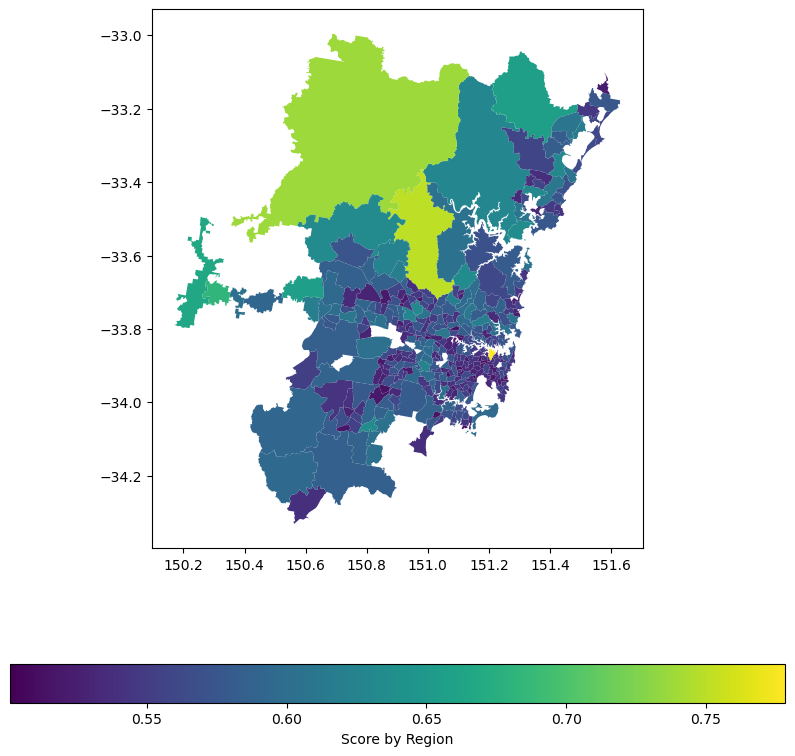

In [278]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming scaler_score_df is your existing DataFrame and its 'geometry' column already contains shapely geometries
gdf = gpd.GeoDataFrame(scaler_score_df, geometry='geometry')

# Set the CRS if it is known and not already set
if gdf.crs is None:
    gdf.set_crs('EPSG:4283', inplace=True)  # Replace 'EPSG:4283' with the correct CRS if different

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,column='zscore', legend=True,
         legend_kwds={'label': "Score by Region", 'orientation': "horizontal"})
plt.show()

### Transportation Stops Density
(Refer to Report for detailed analysis)

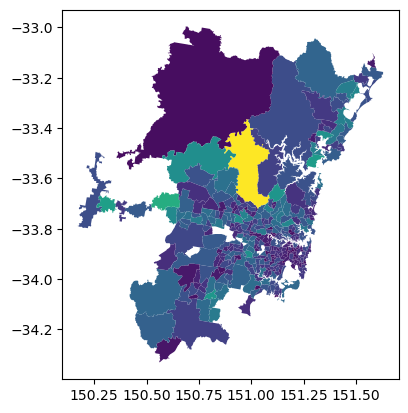

In [201]:
gdf.plot(column='stop_score', cmap='viridis')
plt.show()

### Business Desity Visualization
(Refer to Report for detailed analysis)

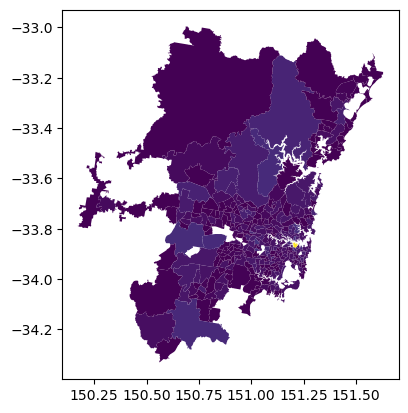

In [279]:
gdf.plot(column='business_score', cmap='viridis')
plt.show()

### SA2 Boundaries

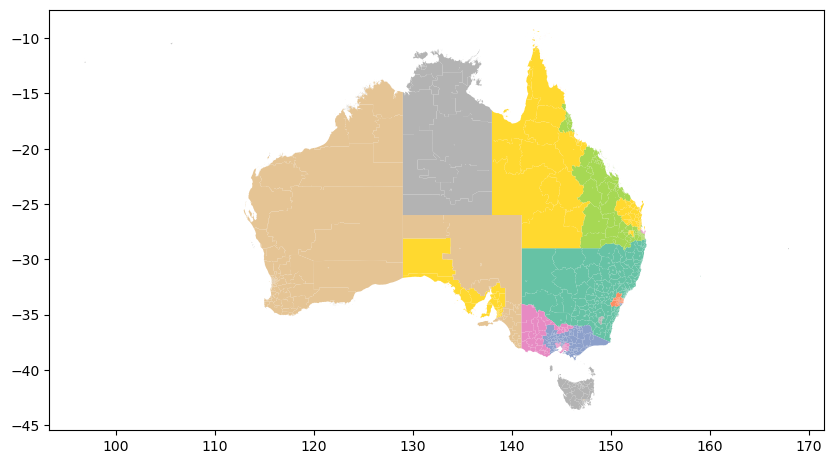

In [88]:
sa2_boundaries = gpd.read_file('SA2_2021_AUST_GDA2020.shp')sa2_boundaries
sa2_boundaries.crs
sa2_boundaries.plot(cmap='Set2', figsize=(10, 10));

### Residual Plots of Score Regression

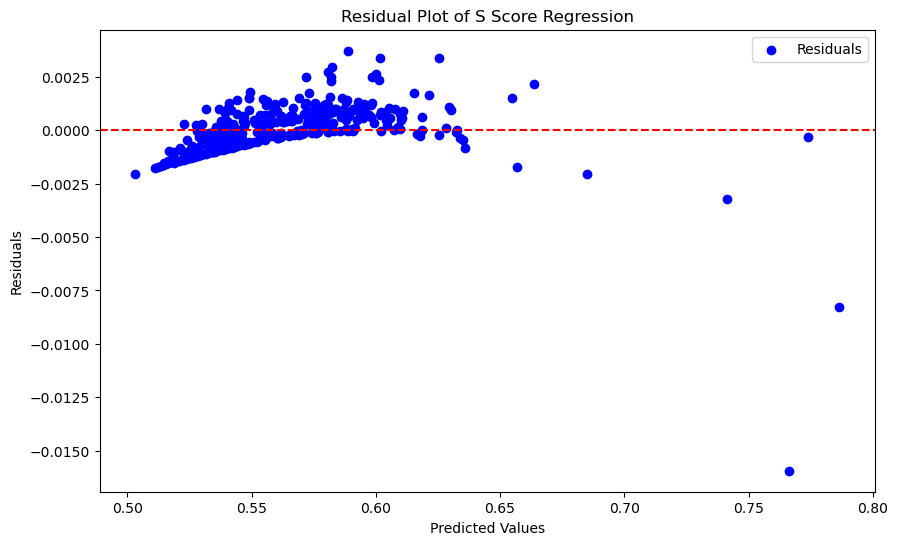

In [190]:
from sklearn.linear_model import LinearRegression
gdf_clean = gdf.dropna(subset=['zscore', 'stop_score', 'poll_score', 'school_score','business_score'])

# Define features (predictors) and target
X = gdf_clean[['stop_score', 'poll_score', 'school_score','business_score']]  # Features
y = gdf_clean['zscore'] 

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Line at zero to indicate no residual
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot of S Score Regression')
plt.legend()
plt.show()


### Correlation Heatmap

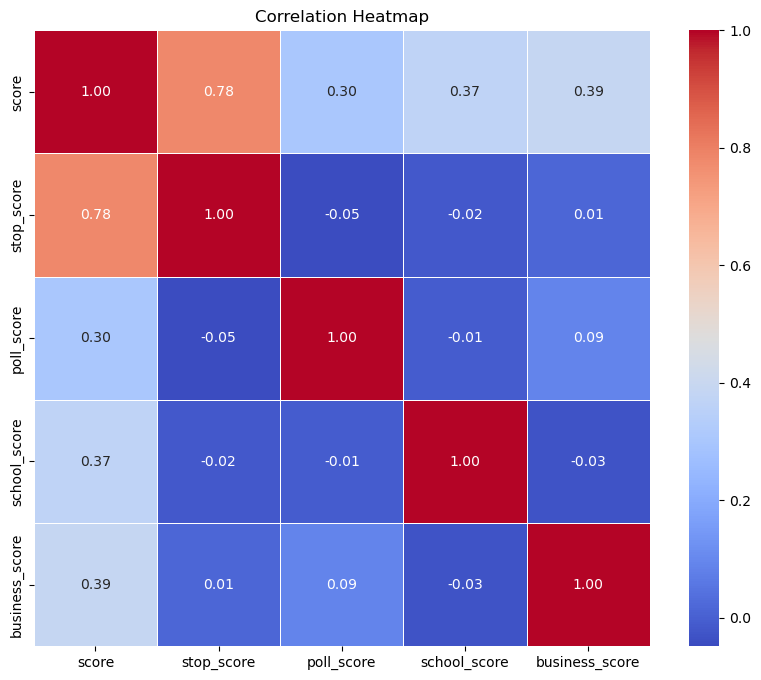

In [281]:
import seaborn as sns
gdf_scores = gdf[['zscore', 'stop_score', 'poll_score', 'school_score','business_score']].rename(columns={'zscore': 'score'}).dropna()
corr_matrix = gdf_scores.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Correlation between score and median income
(Refer to Report for detailed analysis)

In [175]:
merged_df['zscore'] = pd.to_numeric(merged_df['zscore'], errors='coerce')
merged_df['median_income'] = pd.to_numeric(merged_df['median_income'], errors='coerce')
correlation = merged_df['zscore'].corr(merged_df['median_income'])
print(f"The correlation between z_score and median income is: {correlation:.3f}")

The correlation between z_score and median income is: -0.160


### Scatter plot of relationship of Score and Median income
(Refer to Report for detailed analysis)

Text(0.5, 0, 'Score')

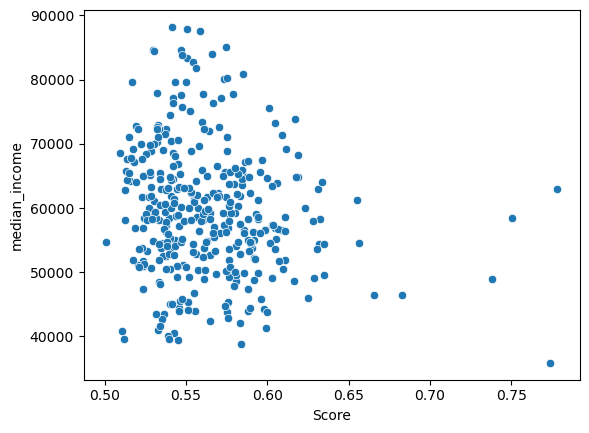

In [196]:
sns.scatterplot(x='zscore', y='median_income', data=merged_df)
plt.xlabel('Score')

### Heatmap of correlation between Score and Median income
(Refer to Report for detailed analysis)

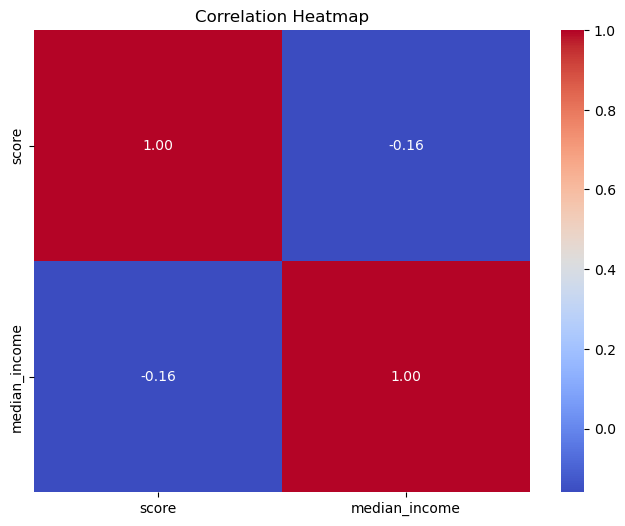

In [197]:
# Renaming the 'zscore' column to 'score'
merged_df.rename(columns={'zscore': 'score'}, inplace=True)

# Calculating the correlation matrix for the renamed columns
corr_matrix = merged_df[['score', 'median_income']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()